# CO2I Regression Notebook

In [1]:
import mysql.connector
import numpy as np
import pandas as pd
import scipy.stats as st
import os.path
import time
# Linear regression
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error
from sklearn.utils import resample
# KRR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
from math import ceil
# GPR (Kriging)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, DotProduct, ConstantKernel, Matern
# Local regression
from sklearn.neighbors import KNeighborsRegressor
import statsmodels.api as sm
# Splines
from scipy.interpolate import UnivariateSpline, LSQUnivariateSpline
# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context("talk", rc={"font.size":16,"axes.titlesize":24,"axes.labelsize":20})
mpl.rcParams['agg.path.chunksize'] = 10000

#### Load Data

In [2]:
server = mysql.connector.connect(user="apark2",
                                 password="Mindinmsight@1",
                                 host="127.0.0.1",
                                 database="widap")
# Seems to only want 1 connection at a time, for one user. Otherwise, Interface Error
query = server.cursor(buffered=True)

In [29]:
def getCO2Idata(orispl, unit):
    query = "SELECT \
                gload, \
                CO2_MASS / (gload * op_time) as CO2I \
            FROM \
                widap.data \
            WHERE ORISPL_CODE = " + str(orispl) + " AND UNITID = '" + str(unit) + "' "
            # "AND SUBSTR(OP_DATE, 1, 4) = '2017'"
    data = pd.read_sql(query, server)
    CO2Idata = data[data["gload"] > 0.1] # always filter for 'on'
    CO2Idata = CO2Idata[CO2Idata["CO2I"] > .35] # has some physical CO2 data recorded
    return CO2Idata

In [73]:
def get_valid_filename(s):
    """
    Taken from django: https://github.com/django/django/blob/master/django/utils/text.py
    
    Return the given string converted to a string that can be used for a clean
    filename. Remove leading and trailing spaces; convert other spaces to
    underscores; and remove anything that is not an alphanumeric, dash,
    underscore, or dot.
    >>> get_valid_filename("john's portrait in 2004.jpg")
    'johns_portrait_in_2004.jpg'
    """
    s = str(s).strip().replace(' ', '_')
    return re.sub(r'(?u)[^-\w.]', '', s)

#### Traditional heat rate curve

Scatter only

In [30]:
def plotCO2I(orispl, unit):
    data = getCO2Idata(orispl, unit)
    fig = plt.figure(figsize=(10, 6))
    x = data["gload"]
    y = data["CO2I"]
    plt.scatter(x, y, s=0.1)
    plt.xlabel('Capacity Factor [MW/MW]')
    plt.ylabel('CO2 Intensity \n [tonnes CO2 / MWh]')
    plt.ylim([0, 4])
    plt.title("CO2I Curve: " + str(orispl) + "_" + str(unit))
    plt.savefig(str(orispl) + "_" + str(unit) + ".png", dpi=1000, bbox_inches="tight")
    plt.show()
    return

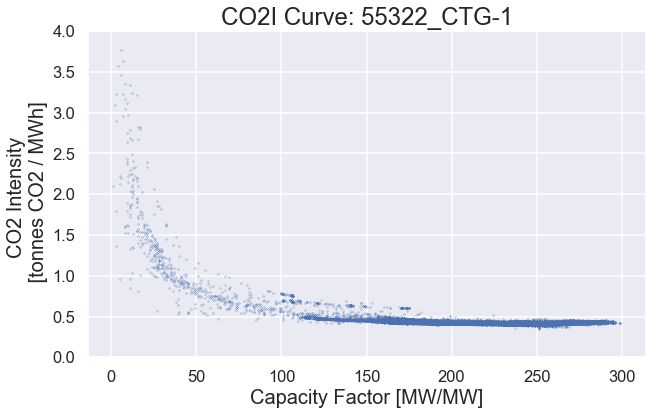

In [31]:
plotCO2I(55322, 'CTG-1')

Scatter + contour

In [6]:
def contour_cloud(x, y):
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()

    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    plt.ylim([0, 10])
    top = f.max()
    bottom = f.min()
    step = (top - bottom) / 5
    color_levels = np.arange(0.0, top, step) + step
    print(color_levels)
    return xx, yy, f, color_levels

In [7]:
# x, y = data["gload"], data["CO2I"]
# xmin, xmax = x.min(), x.max()
# ymin, ymax = y.min(), y.max()

# xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
# positions = np.vstack([xx.ravel(), yy.ravel()])
# values = np.vstack([x, y])
# kernel = st.gaussian_kde(values)
# f = np.reshape(kernel(positions).T, xx.shape)

# plt.ylim([0, 10])
# top = f.max()
# bottom = f.min()
# step = (top - bottom) / 8
# print(top)
# print(step)
# color_levels = np.arange(0.0, top, step) + step
# print(color_levels)
# # return xx, yy, f, color_levels

Mine

In [8]:
def createContours(x, y):
    # x, y = your 2D data
    # f = evaluated 2D data
    k = int(1e3)  # number of points to subsample for contours
    xx, yy = np.mgrid[0:x.max():50j, 0:y.max():50j]  # mag of complex number = number of points bt start and stop
    positions = np.vstack([xx.ravel(), yy.ravel()])
    x_y = np.vstack([x, y])
#     indices = np.random.randint(0, x_y.shape[0], k)
#     contours_here = x_y[:, indices]
    kernel = st.gaussian_kde(x_y)
    f = np.reshape(kernel(positions).T, xx.shape)
    print('f shape', f.shape)
    top = f.max()
    step = top // 8
    color_levels = np.arange(0.0, top, step) + step
    print(color_levels)
    return xx, yy, f, color_levels

In [9]:
def plotCO2I_scatter_contour(data, orispl, unit):
    fig = plt.figure(figsize=(10, 6))
    x = data["gload"]
    y = data["CO2I"]
    
    plt.scatter(x, y, s=0.1)
    plt.contourf(*createContours(x, y), cmap='hot', alpha=0.5)  # alpha = blending value
    
    plt.xlabel('Capacity Factor [MW/MW]')
    plt.ylabel('CO2 Intensity \n [tonnes CO2 / MWh]')
    plt.ylim([0, 10])
    plt.title("CO2I Curve: " + str(orispl) + "_" + str(unit))
    plt.savefig("CO2I_curve/" + str(orispl) + "_" + str(unit) + ".png", dpi=1000, bbox_inches="tight")
    plt.show()
    return

In [10]:
# fig = plt.figure(figsize=(10, 6))
# data = getCO2Idata(55322, 'CTG-1')
# x = data["gload"]
# y = data["CO2I"]

# fig = plt.gcf()
# ax = plt.gca()

# plt.scatter(x, y, s=0.1)
# plt.contourf(*contour_cloud(x, y), cmap='hot', alpha=0.5)
# plt.xlabel('Capacity Factor [MW/MW]')
# plt.ylabel('CO2 Intensity \n [tonnes CO2 / MWh]')
# plt.ylim([0, 3])
# # plt.title("CO2I Curve: " + str(orispl) + "_" + str(unit))
# # plt.savefig("CO2I_curve/" + str(orispl) + "_" + str(unit) + ".png", dpi=1000, bbox_inches="tight")
# plt.show()

## Log fits

##### Log-linear fit

Let's try logging P (x-axis)

In [11]:
def logLinearCO2IFit(data, orispl, unit):
#     data = getCO2Idata(orispl, unit)
    CO2I = data["CO2I"]

    # linear regression on log(P)
    P = data['gload']
    Plog = np.log(P).values.reshape(-1, 1) # log power output [MW]
    LR = LinearRegression().fit(Plog, CO2I)
#     y_pred = LR.coef_[0]*Plog + LR.intercept_  # same as line below, but slower
    y_pred = LR.predict(Plog)
    MAE = mean_absolute_error(CO2I, y_pred)
    MAPE = np.mean(np.abs((CO2I - y_pred.flatten())) / CO2I) * 100
    
    print('Log-linear regression')
    print('MAE: ', round(MAE, 6))
    print('MAPE: ', round(MAPE, 4), '%')
    print('Corr coeff:', round(LR.score(Plog, CO2I), 6))
    print('----------------------')
    
    linParams = np.array([LR.coef_[0], LR.intercept_])
    expParams = np.exp(linParams)
    x_lin = np.linspace(Plog.min(), Plog.max(), 1000)
    y_pred = LR.coef_[0]*x_lin + LR.intercept_

    fig = plt.figure(figsize=(15,8))
    plt.ylim([0, 4])
    plt.xlim([0, P.max() + 10])
    plt.scatter(P, CO2I, s=1)#, c='orange')
    plt.plot(np.exp(x_lin), y_pred, color='darkgreen')
    plt.xlabel('log(Power) [MW]')
    plt.ylabel('CO2 Intensity \n [tonnes CO2 / MWh]')
    plt.title("CO2I Curve: " + str(orispl) + "_" + str(unit))
    plt.savefig(str(orispl) + "_" + str(unit) + "log_linear_fit.png", bbox_inches="tight")
    plt.show()
    
#     fig = plt.figure(figsize=(15,8))
#     plt.ylim([0, 4])
#     plt.xlim([0, Plog.max() + 10])
#     plt.scatter(Plog, CO2I, s=1)#, c='orange')
#     plt.plot(x_lin, y_pred, color='darkgreen')
#     plt.xlabel('Power [MW]')
#     plt.ylabel('CO2 Intensity \n [tonnes CO2 / MWh]')
#     plt.title("CO2I Curve: " + str(orispl) + "_" + str(unit))
#     plt.show()
    return

Log-linear regression
MAE:  2.743591
MAPE:  256.6298 %
Corr coeff: 0.564083
----------------------


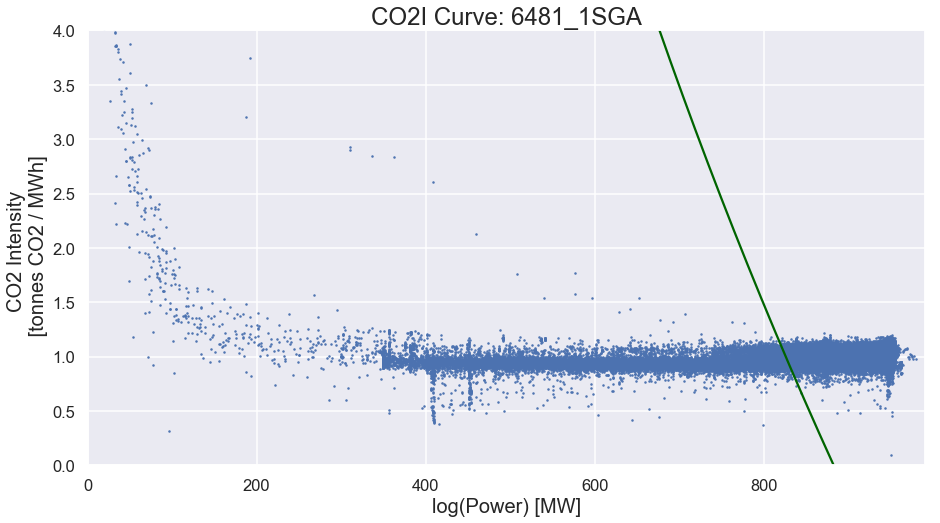

In [12]:
data = getCO2Idata(6481, '1SGA')
logLinearCO2IFit(data, 6481, '1SGA')

Log-linear regression
MAE:  2.743591
MAPE:  256.6298 %
Corr coeff: 0.564083
----------------------


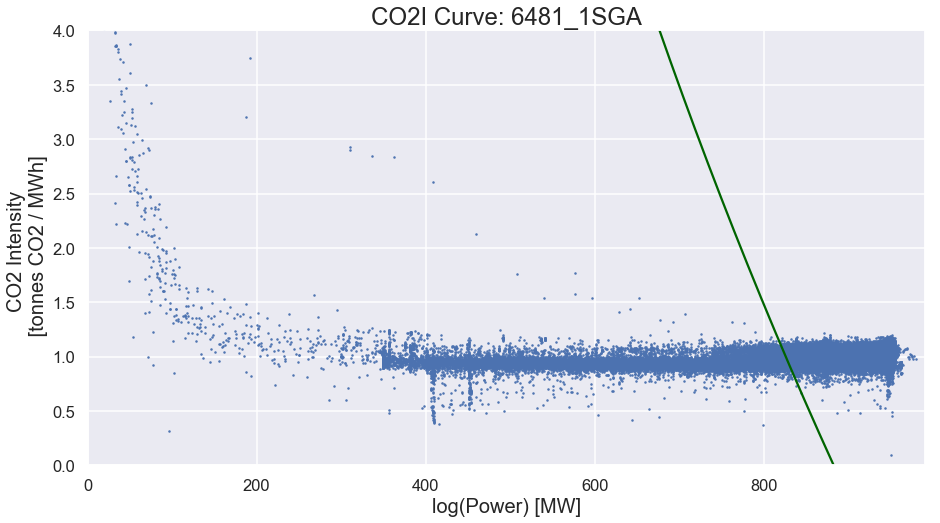

In [13]:
logLinearCO2IFit(data, 6481, '1SGA')

Note that these fits do not have a shift, so instead of leveling off, they asymptotically approach $y = 0$.

##### Log-log fit

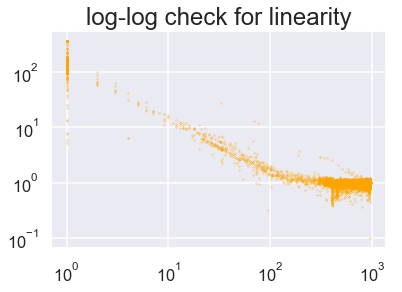

In [14]:
plt.scatter(data['gload'], data['CO2I'], color='orange', s=0.1)
plt.xscale('log')
plt.yscale('log')
plt.title('log-log check for linearity')
plt.show()

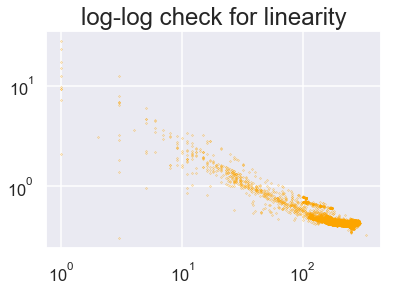

In [55]:
data = getCO2Idata(55322, 'CTG-1')
plt.scatter(data['gload'], data['CO2I'], color='orange', s=0.1)
plt.xscale('log')
plt.yscale('log')
plt.title('log-log check for linearity')
plt.show()

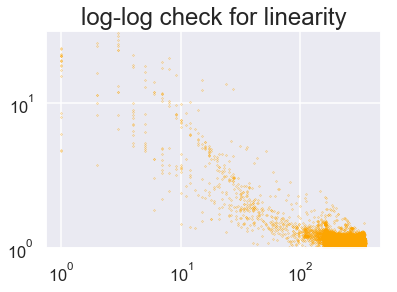

In [61]:
data = getCO2Idata(6076, '1')
plt.scatter(data['gload'], data['CO2I'], color='orange', s=0.1)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1, 10**1.5])
plt.title('log-log check for linearity')
plt.show()

Data seems a bit more linear when both axes are log-scale. However, the tail is still decidely not linear.

In [15]:
def logLogFit(orispl, unit):
    # Fetch and transform data
    data = getCO2Idata(orispl, unit)
    CO2I_log = np.log(data["CO2I"]).values.reshape(-1, 1)
    P_log = np.log(data["gload"]).values.reshape(-1, 1)
    P_log_min = P_log.min()
    P_log_max = P_log.max()
    
    # fit linear regression on log(CO2I) vs log(P)
    LR = LinearRegression().fit(P_log, CO2I_log)
    
    # test accuracy
    y_test = LR.predict(P_log)
    MAE = mean_absolute_error(CO2I_log, y_test)
#     MAPE = np.mean(np.abs((CO2I_log - y_test.flatten())) / CO2I_log) * 100
    
    # evaluate linear regression
    x_eval = np.linspace(P_log_min, P_log_max, 1000).reshape(-1, 1)
    y_eval = LR.predict(x_eval)
    
    # plot
    print('Log-log regression')
    print('MAE: ', round(MAE, 6))
#     print('MAPE: ', round(MAPE, 4), '%')
    print('Corr coeff:', round(LR.score(P_log, CO2I_log), 6))
    
    fig = plt.figure(figsize=(10,6))
    plt.ylim([0, 4])
    plt.xlim([0, P_log_max])
    plt.scatter(P_log, CO2I_log, s=1)
    plt.plot(x_eval, y_eval, color='purple')
    plt.xlabel('log(Power) [MW]')
    plt.ylabel('log(CO2 Intensity)')
    plt.title("Log-log fit: " + str(orispl) + "_" + str(unit))
    plt.show()
    return

Log-log regression
MAE:  0.119824
Corr coeff: 0.683378


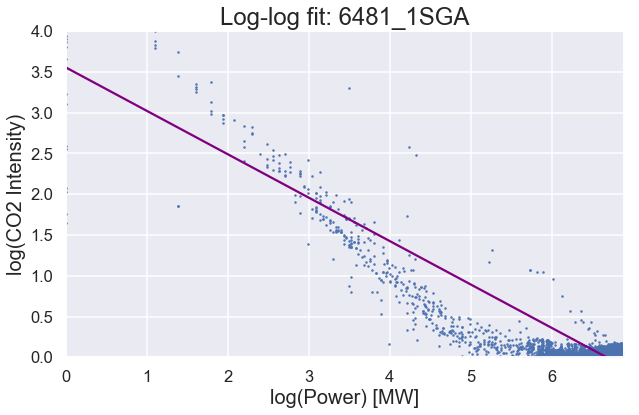

In [16]:
logLogFit(6481, '1SGA')

Log-log regression
MAE:  0.040296
Corr coeff: 0.610277


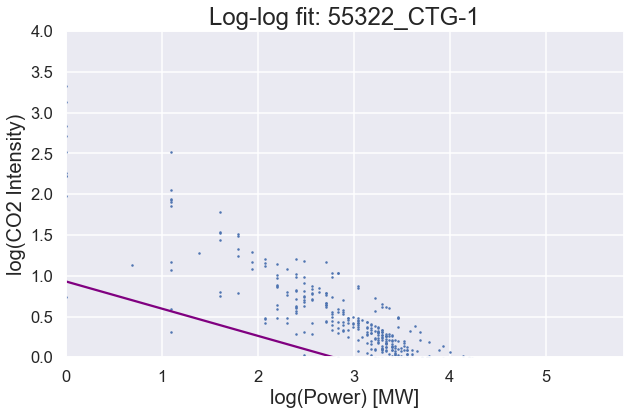

In [17]:
logLogFit(55322, 'CTG-1')

## Polynomial fits

In [18]:
def polyFit(orispl, unit, d):
    # d = degree of polynomial fit
    
    # process data
    data = getCO2Idata(orispl, unit)
    output = data['gload']
    quad = PolynomialFeatures(degree=d, interaction_only=False, include_bias=True)
    P = quad.fit_transform(output.values.reshape(-1, 1))
    CO2I = data["CO2I"]
    # quadratic regression
    LR = LinearRegression().fit(P, CO2I)
    y_pred = LR.predict(P)
    MAE = mean_absolute_error(CO2I, y_pred)
    MAPE = np.mean(np.abs((CO2I - y_pred.flatten())) / CO2I) * 100

    print('Quadratic regression')
    print('MAE: ', round(MAE, 6))
    print('MAPE: ', round(MAPE, 4), '%')
    print('Corr coeff:', round(LR.score(P, CO2I), 6))
    print('----------------------')

    x = np.linspace(output.min(), output.max(), 1000).reshape(-1, 1)
    x_quad = quad.transform(x)
    y_pred = LR.predict(x_quad)

    fig = plt.figure(figsize=(15,8))
    plt.ylim([0, 4])
    plt.xlim([0, output.max() + 10])
    plt.scatter(output, CO2I, s=1)#, c='orange')
    plt.plot(x, y_pred, color='darkgreen')
    plt.xlabel('Capacity Factor [MW/MW]')
    plt.ylabel('CO2 Intensity \n [tonnes CO2 / MWh]')
    plt.title("Polynomial, degree " + str(d) + ": " + str(orispl) + "_" + str(unit))
    plt.show()
    return

##### Quadratic Fit

Quadratic regression
MAE:  0.0312
MAPE:  6.5518 %
Corr coeff: 0.259303
----------------------


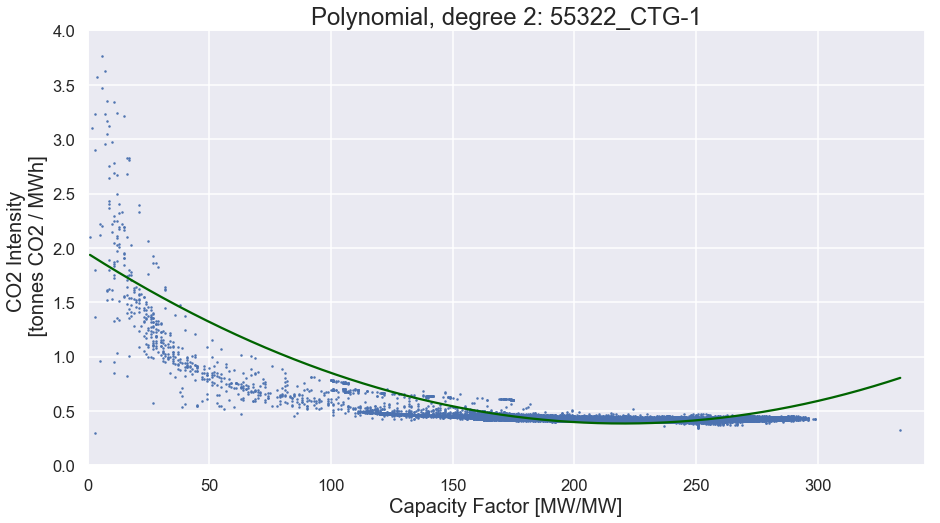

In [19]:
polyFit(55322, 'CTG-1', 2)

##### Cubic Fit

Quadratic regression
MAE:  0.021608
MAPE:  4.2647 %
Corr coeff: 0.341477
----------------------


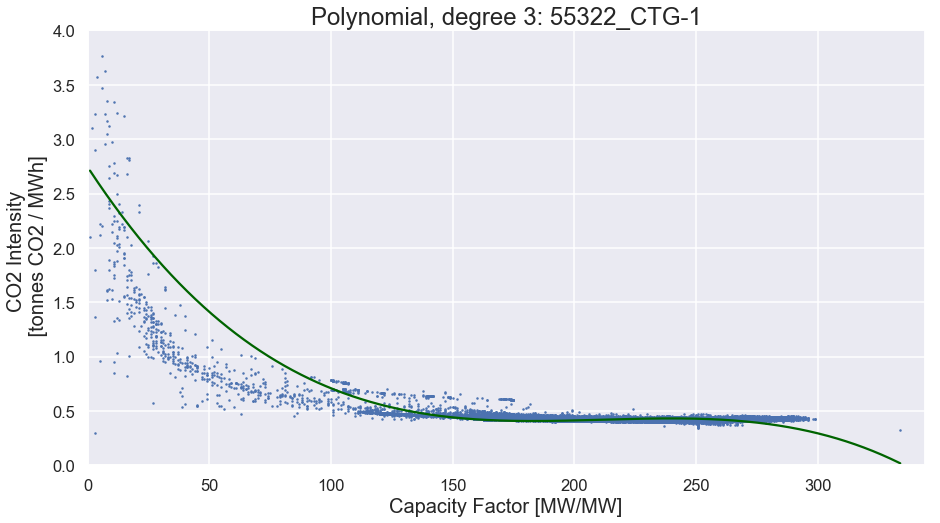

In [20]:
polyFit(55322, 'CTG-1', 3)

##### Quartic Fit

Quadratic regression
MAE:  0.021084
MAPE:  4.1323 %
Corr coeff: 0.404706
----------------------


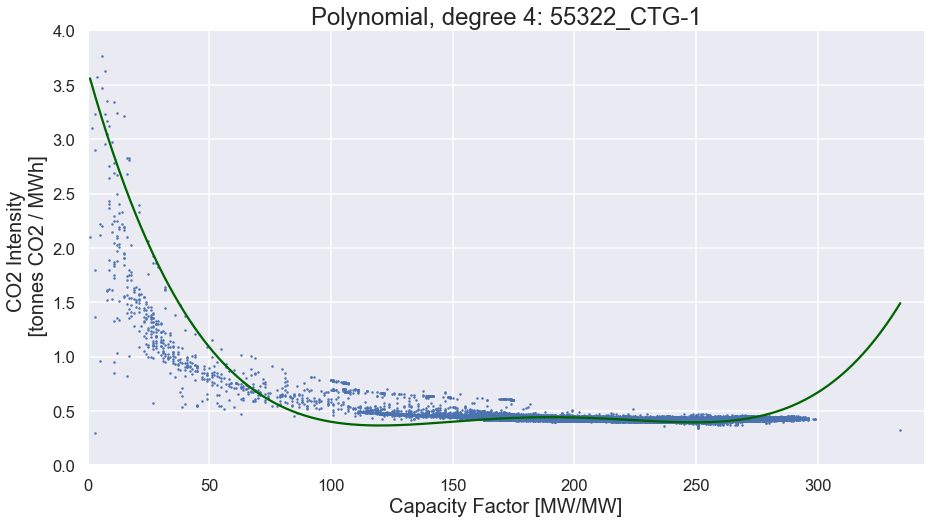

In [21]:
polyFit(55322, 'CTG-1', 4)

## Get a representative subsample

The main problem is that these fits are way too heavily weighted by the modes in which they operate most frequently. We need to sample an equal number of points from bins along the entire power output distribution, then regress on that subsample.

In [6]:
def divideData(data, b=5):
    """
    This function divides data into b evenly sized buckets, and adds the bucket label to the df. 
    data = pd df with CO2I and gload
    b = number of bins. Default to 5.
    """
    capacity = data['gload'].max()
    bins = np.linspace(0.1, capacity, b + 1)  #  right ensures bins[i-1] < x <= bins[i] (includes capacity, and values > 0)
    data['bin'] = np.digitize(data['gload'], bins, right=True)
    return data

In [23]:
# data = getCO2Idata(55322, 'CTG-1')
# capacity = data['gload'].max()
# bins = np.linspace(0.1, capacity, b + 1)  # right ensures bins[i-1] < x <= bins[i] (includes capacity, and values > 0)
# data['bin'] = np.digitize(data['gload'], bins, right=True)
# print(len(bins))
# print(len(data['bin'].unique()))

In [24]:
# def sampleFromBins(data, b=5, n=0):
#     """
#     This function divides the data into b even bins and takes n samples from each bin. 
#     If n isn't defined, it takes, the max number of data points from the lowest bin,
#     since this is typicaly the sparsest for plants, and uses that for each other bin.
#     """
#     rng = np.random.RandomState(0)  # set seed
#     binnedData = divideData(data, b)
#     bins = binnedData['bin'].unique()
#     if n == 0:
#         n = binnedData[binnedData['bin'] == 1].shape[0]
#     sample = [resample(binnedData[binnedData['bin'] == i], replace=True, n_samples=n) for i in bins]
#     sample = pd.concat(sample)
#     return sample

In [25]:
# def abs_z_score(CO2I, b, means, stds):
#     return abs(CO2I - means.iloc[b][0]) / stds.iloc[b][0]
#     sample['gload_zScore'] = np.vectorize(abs_z_score)(sample['CO2I'], sample['bin'], means, stds)

In [57]:
def sampleFromBins(data, b=25, n=0):
    """
    This function divides the data into b even bins, removes outliers in the y
    direction within each bin, and takes n samples from each bin. It also searches
    for outliers at the high end of the x domain--the only open end of the domain. -- NEED TO CHECK ON PEAKER
    If n isn't defined, it takes, the max number of data points from the lowest bin,
    since this is typicaly the sparsest for plants, and uses that for each other bin.
    """
    # divide into bins and sample n from each
    rng = np.random.RandomState(0)  # set seed
    binnedData = divideData(data, b)
    bins = binnedData['bin'].unique()
    if n == 0:
        n = binnedData[binnedData['bin'] == 1].shape[0]
    sample = [resample(binnedData[binnedData['bin'] == i], replace=True, n_samples=n) for i in bins]
    sample = pd.concat(sample)
    
    # calculate z-score
    means = sample[['CO2I','bin']].groupby(['bin']).mean()
    stds = sample[['CO2I', 'bin']].groupby(['bin']).std()
    sample['mean'] = sample['bin'].map(means['CO2I'])
    sample['std'] = sample['bin'].map(stds['CO2I'])
    sample.loc[sample['std'] < 1e-4, 'std'] = 1 # avoid divide by 0 for gload outlier
    
    # remove outliers in CO2I
 #     sample = sample[sample['std'] > 0.0]  # If one high gload outlier, it'll get dropped because std(1 value) == 0
    sample['CO2I_zScore'] = np.vectorize(lambda CO2I, avg, std: abs(CO2I - avg) / std)(sample['CO2I'], sample['mean'], sample['std'])
    sample = sample[(sample['CO2I_zScore'] < 2.5) & (sample['std'] > 0.0)]  # ~98.5% CI
    
    # TODO: Remove outliers at upper end of gload -- CONSISTENT WITH SQL SCRIPT
    
    # convert gload --> CF. Drop mean, std, gload. Pass back capacity.
    capacity = sample['gload'].max()
    sample.loc[:, 'gload'] /= capacity
    sample.drop(columns=['CO2I_zScore', 'mean', 'std'])
    return sample, capacity

In [58]:
def representative_subsample(orispl, unit, b=25, n=0):
    data = getCO2Idata(orispl, unit)
    if data.shape[0] <= 1:
        print('No data retrieved.')
        return None, None
    else:
        sample, capacity = sampleFromBins(data, b, n)
        return sample, capacity

In [59]:
def plotCO2I_subsample(data, orispl, unit):
    plt.figure(figsize=(10, 6))
    x = data['gload']
    y = data['CO2I']
    cm = plt.cm.get_cmap('viridis')
    z = data['bin'].values  # for some reason, didn't like a df here.
    normalize = mpl.colors.Normalize(vmin=1, vmax=z.max())
    sc = plt.scatter(x, y, s=0.5, c=z, cmap=cm)
    plt.xlabel('Capacity Factor [MW/MW]')
    plt.ylabel('CO2 Intensity \n [tonnes CO2 / MWh]')
    plt.ylim([0, 4])
    plt.title("CO2I Curve: " + str(orispl) + "_" + str(unit))
    plt.savefig("CO2Icurve/" + str(orispl) + "_" + str(unit) + ".png", dpi=1000, bbox_inches="tight")
    plt.colorbar(sc, label='Bin number')
    plt.show()
    return

These plots show the sampling technique. Equal numbers of points are taken from each of the 6 bins.

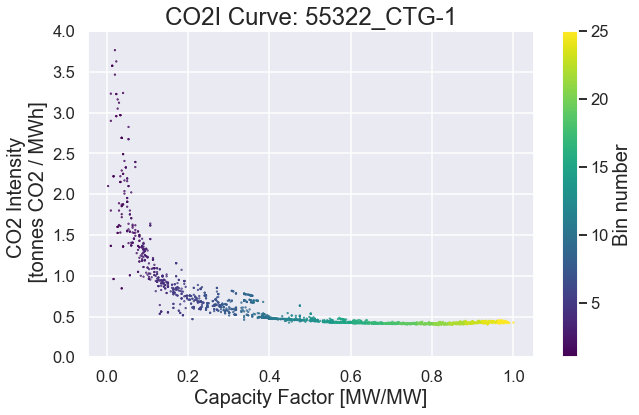

In [49]:
sample, capacity = representative_subsample(55322, 'CTG-1')
plotCO2I_subsample(sample, 55322, 'CTG-1')

A troubling problem popped up here. The max point is was the only one in its bucket, it got sampled hundreds of times. This was fixed with kwarg 'right=True' to correct ranges of np.digitize.

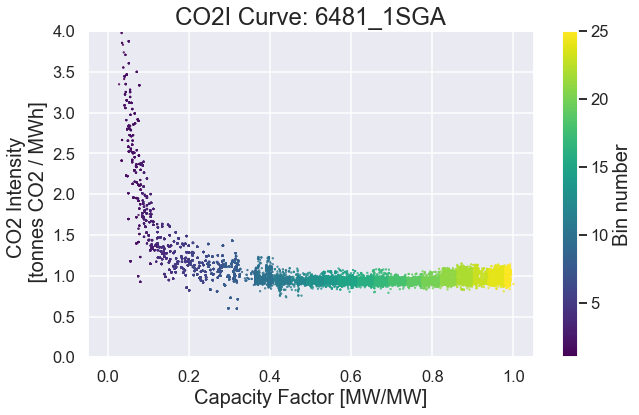

In [30]:
sample, capacity = representative_subsample(6481, '1SGA')
plotCO2I_subsample(sample, 6481, '1SGA')                   

The same effect occured here as well.

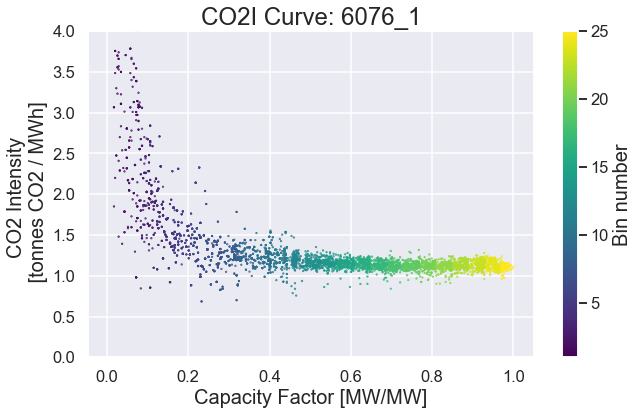

In [31]:
sample, capacity = representative_subsample(6076, '1')
plotCO2I_subsample(sample, 6076, '1')

## Non-parametric methods

None of these methods are working very well. We should just use a non-parametric method, like kernel ridge regression (KRR) or SVR. We'll use KRR with a radial basis function (RBF) kernel.

On subsample

4260
2982


C:\Users\apark2\.julia\conda\3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


KRR grid search run in 39.8595 s
GPR fit in 0.001 s
KRR model prediction in 0.3791 s
GPR model prediction in 15.7805 s


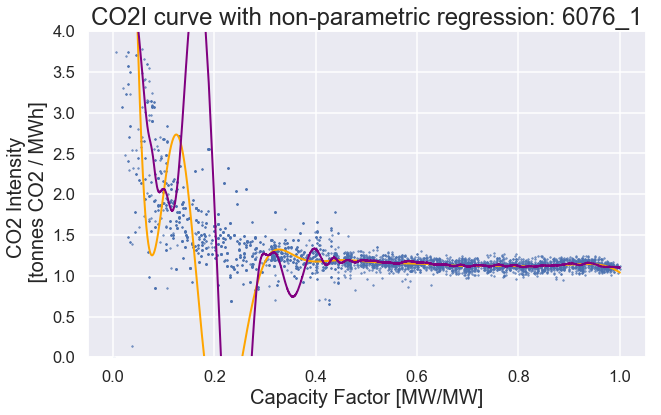

In [32]:
# get and split data
orispl = 6076
unit = '1'
sample, capacity = representative_subsample(6076, '1')
n = sample.shape[0]
f = 0.7  # fraction used to train
train_size = ceil(f * n)
print(n)
print(train_size)

x_test = sample['gload'].iloc[train_size:].values.reshape(-1, 1)
y_test = sample['CO2I'].iloc[train_size:].values.reshape(-1, 1)
x_train = sample['gload'].iloc[:train_size].values.reshape(-1, 1)
y_train = sample['CO2I'].iloc[:train_size].values.reshape(-1, 1)
x_plot = np.linspace(0, sample['gload'].max(), 10000).reshape(-1, 1)

# fit with grid search
krr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=5,
                  param_grid={"alpha": [1e0, 1e-2, 1e-4, 1e-6],  # small reduce var
                              "gamma": np.logspace(-2, 2, 5)})
t0 = time.time()
krr.fit(x_train, y_train)
t_krr = time.time() - t0
print('KRR grid search run in {} s'.format(round(t_krr, 4)))

t0 = time.time()
gp_kernel = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=3.)

# ConstantKernel(0.1, (0.01, 10.0)) * \
#             (DotProduct(sigma_0=2.7, sigma_0_bounds=(0.1, 10.0)) ** 2)
gpr = GaussianProcessRegressor(kernel=gp_kernel)
t_gpr = time.time() - t0
print('GPR fit in {} s'.format(round(t_gpr, 4)))
gpr.fit(x_train, y_train)

# # fit less wiggle without GS_CV
# krr2 = KernelRidge(kernel='rbf', gamma=1e-2, alpha=1e-2).fit(x_train, y_train)
# y_pred2 = krr2.predict(x_plot)

# predict
t0 = time.time()
y_pred_krr = krr.predict(x_plot)
t_krr = time.time() - t0
print('KRR model prediction in {} s'.format(round(t_krr, 4)))

t0 = time.time()
y_pred_gpr = gpr.predict(x_plot)
t_gpr = time.time() - t0
print('GPR model prediction in {} s'.format(round(t_gpr, 4)))


# plot results
fig = plt.figure(figsize=(10, 6))
plt.scatter(sample['gload'], sample['CO2I'], s=0.5)
plt.plot(x_plot, y_pred_krr, 'orange', linewidth=2)
plt.plot(x_plot, y_pred_gpr, 'purple', linewidth=2)
plt.xlabel('Capacity Factor [MW/MW]')
plt.ylabel('CO2 Intensity \n [tonnes CO2 / MWh]')
plt.ylim([0, 4])
plt.title("CO2I curve with non-parametric regression: " + str(orispl) + "_" + str(unit))
plt.savefig(str(orispl) + "_" + str(unit) + ".png", dpi=1000, bbox_inches="tight")
plt.show()

### Local regression

Models way too flexible. Let's try local regression (LOESS, LOWESS, KNN)

KRR model prediction in 0.0157 s
KRR model prediction in 0.0156 s
KRR model prediction in 0.0156 s
KRR model prediction in 0.0156 s
KRR model prediction in 0.0313 s


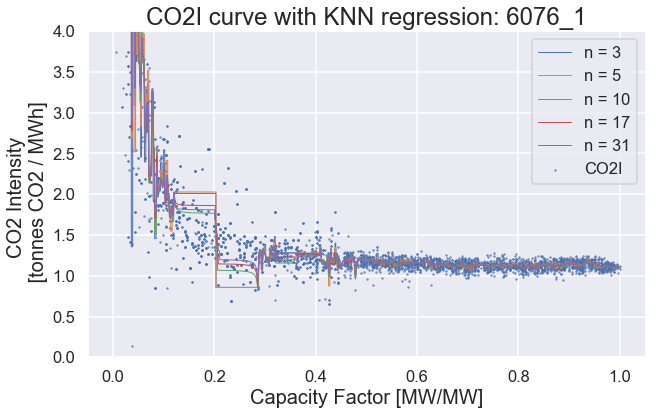

In [33]:
fig = plt.figure(figsize=(10, 6))

for n in np.logspace(0.5, 1.5, 5, dtype=int):
    KNN = KNeighborsRegressor(n, weights='distance')
    t0 = time.time()
    KNN.fit(x_train, y_train)
    t_KNN = time.time() - t0

    # predict
    t0 = time.time()
    y_pred_KNN = KNN.predict(x_plot)
    t_KNN = time.time() - t0
    print('KRR model prediction in {} s'.format(round(t_KNN, 4)))

    # plot results     
    plt.plot(x_plot, y_pred_KNN, linewidth=1, label='n = ' + str(n))
    

plt.scatter(sample['gload'], sample['CO2I'], s=0.5)
plt.xlabel('Capacity Factor [MW/MW]')
plt.ylabel('CO2 Intensity \n [tonnes CO2 / MWh]')
plt.ylim([0, 4])
plt.title("CO2I curve with KNN regression: " + str(orispl) + "_" + str(unit))
plt.savefig(str(orispl) + "_" + str(unit) + ".png", dpi=1000, bbox_inches="tight")
plt.legend()
plt.show()

Still not really smooth enough. Perhaps LOWESS can help smooth predictions.

In [67]:
def LOWESS(data, orispl, unit, fractions, dataFlag):
    """
    This fits with weighted local regression.
    Data = X and y for fitting
    Orispl, unit = Power generating unit
    Fractions = Fractions of data to try for fit
    dataFlag = Indicates type of datat used: ['full', 'bootstrap', or 'rep_sample']
    """
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_prop_cycle('color',plt.cm.inferno(np.linspace(0.2,1,8)))

    print('n points =', data.shape[0])
    x = data['gload']
    y = data['CO2I']

    for f in fractions: #[0.08, 0.1, 0.2]:
        lowess = sm.nonparametric.lowess
        t0 = time.time()
        # NOTE: y, x for some reason
        x_y_pred = lowess(y, x, frac=f, it=3)
        t = time.time() - t0
        print('LOWESS model prediction in {} s'.format(round(t, 4)))
        # plot results     
        ax.plot(x_y_pred[:, 0], x_y_pred[:, 1], linewidth=1, label='frac = ' + str(round(f, 3)))

    plt.scatter(x, y, s=0.5)
    plt.xlabel('Capacity Factor [MW/MW]')
    plt.ylabel('CO2 Intensity \n [tonnes CO2 / MWh]')
    plt.ylim([0, 4])
    plt.title("CO2I curve with non-parametric regression: " + str(orispl) + "_" + str(unit))
    plt.legend()
    plt.savefig(str(orispl) + "_" + str(unit) + ".png", dpi=1000, bbox_inches="tight")
    plt.show()
    return

n points = 4260
LOWESS model prediction in 0.0781 s
LOWESS model prediction in 0.0781 s
LOWESS model prediction in 0.0979 s
LOWESS model prediction in 0.0937 s
LOWESS model prediction in 0.1094 s


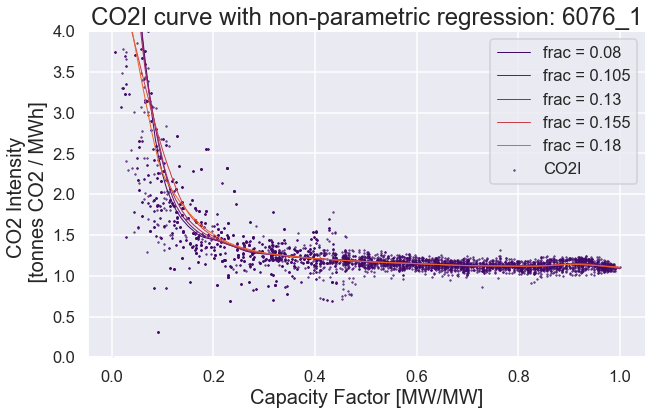

In [35]:
orispl = 6076
unit = '1'
sample, capacity = representative_subsample(orispl, unit)
LOWESS(sample, orispl, unit, np.linspace(0.08, .18, 5) , 'rep_sample')

This is starting to look a lot better. However, at higher fractions, the points at low power output are being dragged to the right by local weighting. Lower fractions are bumpier. It would serve us to eliminate this bias.

Let's try it again with all data.

n points = 129971


C:\Users\apark2\.julia\conda\3\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
C:\Users\apark2\.julia\conda\3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


LOWESS model prediction in 0.5746 s
LOWESS model prediction in 0.9081 s
LOWESS model prediction in 1.1444 s
LOWESS model prediction in 1.3315 s
LOWESS model prediction in 1.598 s


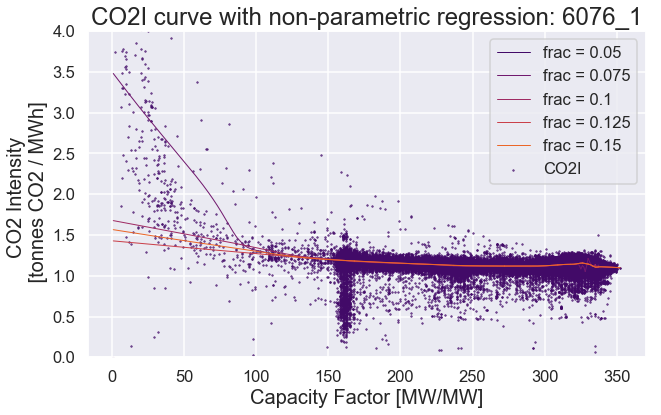

In [36]:
data = getCO2Idata(6076, '1')
LOWESS(data, 6076, '1', np.linspace(0.05, .15, 5), 'full')

Using all points __definitely__ weights the low power output points too heavily. Let's try resampling with a higher number of points, to smooth things out.

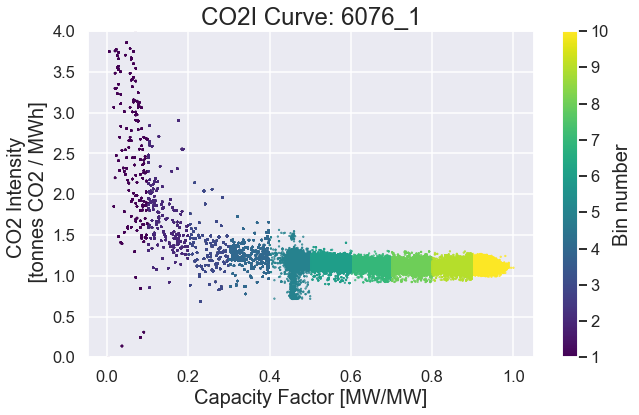

In [37]:
bigSample, capacity = representative_subsample(6076, '1', b=10, n=int(1e4))
plotCO2I_subsample(bigSample, 6076, '1')

Explore a few more plants to see if this works for different patterns.

n points = 241675
LOWESS model prediction in 0.8934 s
LOWESS model prediction in 1.4096 s
LOWESS model prediction in 1.8634 s
LOWESS model prediction in 2.304 s
LOWESS model prediction in 2.7242 s
LOWESS model prediction in 3.1355 s


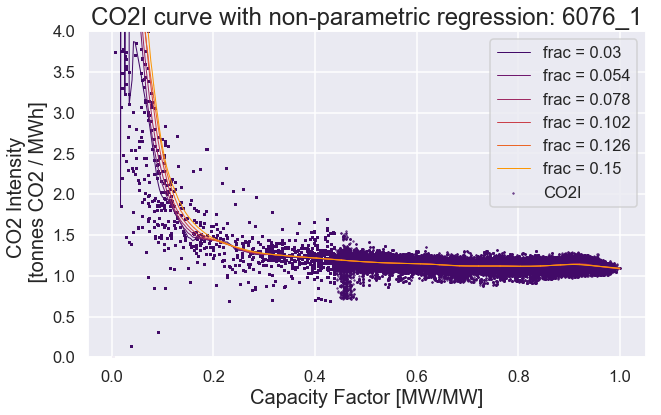

In [38]:
bigSample, capacity = representative_subsample(6076, '1', b=25, n=int(1e4))
LOWESS(bigSample, 6076, '1', np.linspace(0.03, .15, 6), 'rep_sample')

n points = 223076
LOWESS model prediction in 0.7329 s
LOWESS model prediction in 1.1086 s
LOWESS model prediction in 1.4945 s
LOWESS model prediction in 1.8644 s
LOWESS model prediction in 2.1456 s
LOWESS model prediction in 2.4877 s


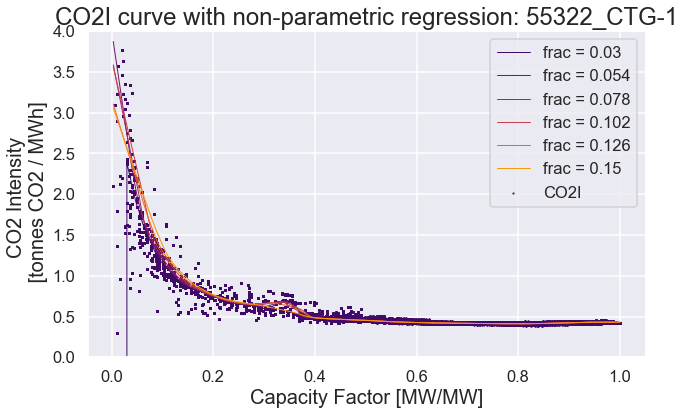

In [39]:
bigSample, capacity = representative_subsample(55322, 'CTG-1', b=25, n=int(1e4))
LOWESS(bigSample, 55322, 'CTG-1', np.linspace(0.03, .15, 6), 'rep_sample')

n points = 243998


C:\Users\apark2\.julia\conda\3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


LOWESS model prediction in 1.4833 s
LOWESS model prediction in 3.3135 s
LOWESS model prediction in 4.4513 s
LOWESS model prediction in 5.5781 s
LOWESS model prediction in 6.5945 s
LOWESS model prediction in 7.7402 s


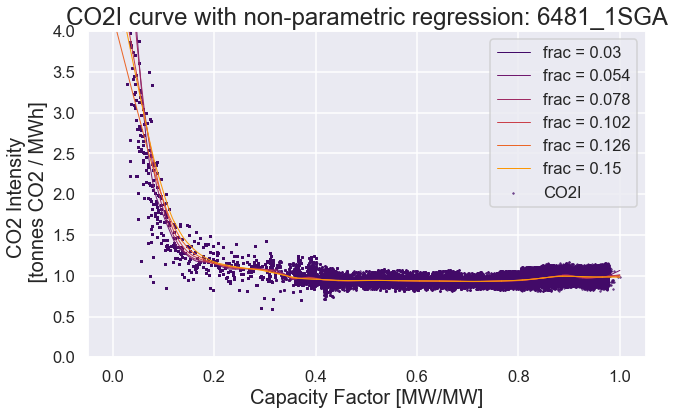

In [40]:
bigSample, capacity = representative_subsample(6481, '1SGA', b=25, n=int(1e4))
LOWESS(bigSample, 6481, '1SGA', np.linspace(0.03, .15, 6), 'rep_sample')

n points = 244763
LOWESS model prediction in 1.7275 s
LOWESS model prediction in 2.8827 s
LOWESS model prediction in 3.9841 s
LOWESS model prediction in 4.8851 s
LOWESS model prediction in 5.851 s
LOWESS model prediction in 6.8116 s


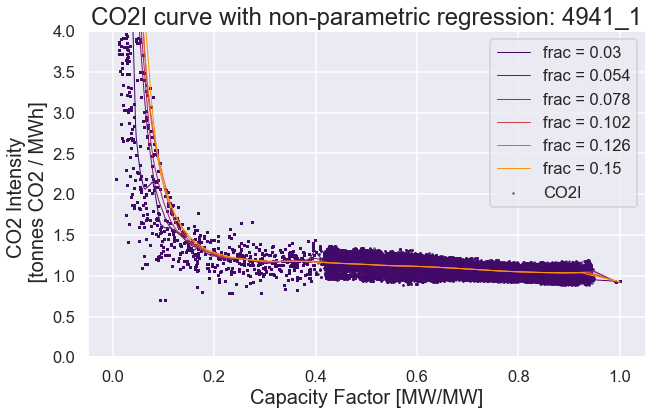

In [41]:
bigSample, capacity = representative_subsample(4941, '1', b=25, n=int(1e4))
LOWESS(bigSample, 4941, '1', np.linspace(0.03, .15, 6), 'rep_sample')

### Splines: The last hope

In [42]:
# maxJitter = 1e-6
# # sample.reset_index(inplace=True)
# sample['gload'] = sample['gload'].apply(lambda gload: gload + np.random.uniform(-maxJitter, maxJitter))
# sample.head()

In [43]:
def jitter(data, col, maxJitter):
    data[col] = data[col].apply(lambda x: x + np.random.uniform(-maxJitter, maxJitter))
    return data

In [44]:
def splineFit(data, orispl, unit, smoothing=None, dataFlag=None):
    """
    This fits data with smoothed splines. Default uses cubic (deg 3).
    data = X and y for fitting
    orispl, unit = Power generating unit
    smoothing = Level of smoothing, affected by number of knots. Larger is smoother.
    dataFlag = Indicates type of datat used: ['full', 'bootstrap', or 'rep_sample']
    """
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_prop_cycle('color',plt.cm.inferno(np.linspace(0.2,1,8)))

    
    maxJitter = 1e-6 
    data = jitter(data, 'gload', maxJitter)  # jitter data ever so slightly
    data.sort_values('gload', ascending=True, inplace=True)  # sort to satisfy np.UnivariateSpline
    
    x = data['gload']
    y = data['CO2I']
    x_plot = np.linspace(0.1, x.max(), 1e3)
    
    if smoothing == None:
        smoothing = [None]
    for smoothie in smoothing:
        t0 = time.time()
        spline = UnivariateSpline(x, y, s=smoothie)
        y_pred = spline(x_plot)
        t = time.time() - t0
        print('Spline model fit + prediction in {} s'.format(round(t, 4)))
        ax.plot(x_plot, y_pred, linewidth=1, label='s = ' + str(smoothie))
    plt.scatter(x, y, s=0.5)
    plt.xlabel('Capacity Factor [MW/MW]')
    plt.ylabel('CO2 Intensity \n [tonnes CO2 / MWh]')
    plt.ylim([0, 4])
    plt.title("CO2I curve with non-parametric regression: " + str(orispl) + "_" + str(unit))
    plt.savefig(str(orispl) + "_" + str(unit) + ".png", dpi=1000, bbox_inches="tight")
    plt.legend()
    plt.show()
    return

C:\Users\apark2\.julia\conda\3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


Spline model fit + prediction in 2.7033 s


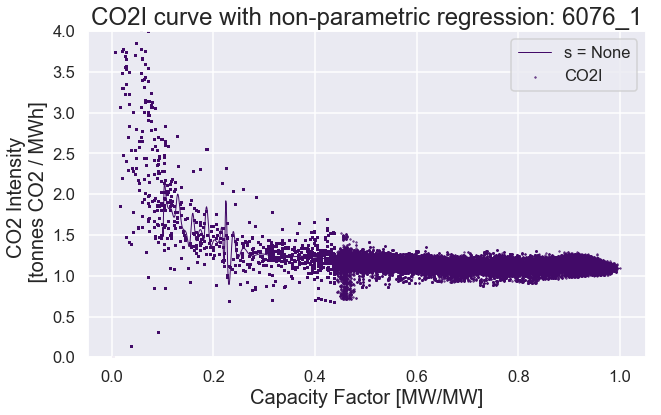

In [45]:
bigSample, capacity = representative_subsample(6076, '1', b=25, n=int(1e4))
splineFit(bigSample, 6076, '1', smoothing=[None])

This spline has 'None' smoothing (almost interpolates). Clearly, it shows significantly variance. Let's smooth it out.

In [46]:
# splineFit(bigSample, 6076, '1', smoothing=[0.5])  # Didn't finish...

For some reason, any positive smoothing seems unsolvable. Let's try manually setting the knot locations.

In [47]:
def splineFit_explicitKnots(data, orispl, unit, knots, dataFlag=None):
    """
    This fits data with smoothed splines. Default uses cubic (deg 3).
    data = X and y for fitting
    orispl, unit = Power generating unit
    knots = Array of knots to use along x-axis. Must be iterable, and can test multiple arrays.
    dataFlag = Indicates type of datat used: ['full', 'bootstrap', or 'rep_sample']
    """
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_prop_cycle('color',plt.cm.inferno(np.linspace(0.2,1,8)))

    
    maxJitter = 1e-6 
    data = jitter(data, 'gload', maxJitter)  # jitter data ever so slightly
    data.sort_values('gload', ascending=True, inplace=True)  # sort to satisfy np.UnivariateSpline
    
    x = data['gload']
    y = data['CO2I']
    x_plot = np.linspace(0.1, x.max(), 1e3)
    
    for knot_array in knots:
        t0 = time.time()
        spline = LSQUnivariateSpline(x, y, knot_array, bbox=[0, 1], ext=0)
        y_pred = spline(x_plot)
        t = time.time() - t0
        print('Spline model fit + prediction in {} s'.format(round(t, 4)))
        ax.plot(x_plot, y_pred, linewidth=1, label='n knots = ' + str(len(knot_array)))
    plt.scatter(x, y, s=0.5)
    plt.xlabel('Capacity Factor [MW/MW]')
    plt.ylabel('CO2 Intensity \n [tonnes CO2 / MWh]')
    plt.ylim([0, 4])
    plt.title("CO2I curve with non-parametric regression: " + str(orispl) + "_" + str(unit))
    plt.savefig(str(orispl) + "_" + str(unit) + ".png", dpi=1000, bbox_inches="tight")
    plt.legend()
    plt.show()
    return

C:\Users\apark2\.julia\conda\3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


Spline model fit + prediction in 0.0469 s
Spline model fit + prediction in 0.0469 s
Spline model fit + prediction in 0.0469 s
Spline model fit + prediction in 0.0312 s
Spline model fit + prediction in 0.0507 s


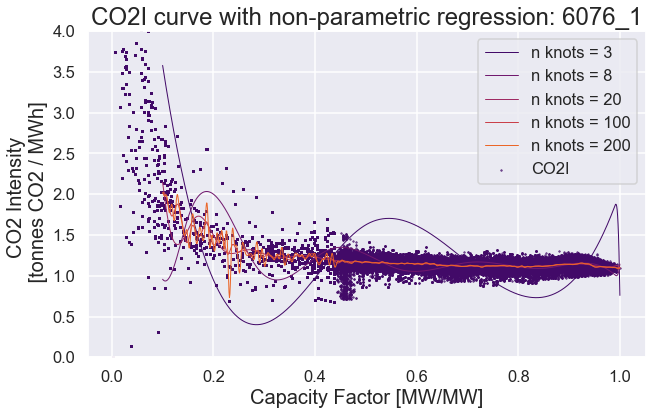

In [48]:
knots = [list(np.linspace(0.01, .99, i)) for i in [3, 8, 20, 100, 200]]  # doesn't like np.arrays(). Something to do with Schoenberg-Whitney conditions
splineFit_explicitKnots(bigSample, 6076, '1', knots, dataFlag=None)

$n = 100$ looks great in the section of the domain with low variance, but it becomes more challenging at the lower power output.

In [49]:
knots = [list(np.logspace(-.99, -0.01, 10)), list(np.logspace(-.99, -0.01, 3))]
knots

[[0.10232929922807542,
  0.13148883844448783,
  0.16895761786607705,
  0.21710342088869547,
  0.2789687494229136,
  0.3584630902452843,
  0.46060996915966596,
  0.5918644051863007,
  0.7605208258206506,
  0.9772372209558107],
 [0.10232929922807542, 0.31622776601683794, 0.9772372209558107]]

C:\Users\apark2\.julia\conda\3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


Spline model fit + prediction in 0.0469 s
Spline model fit + prediction in 0.0469 s


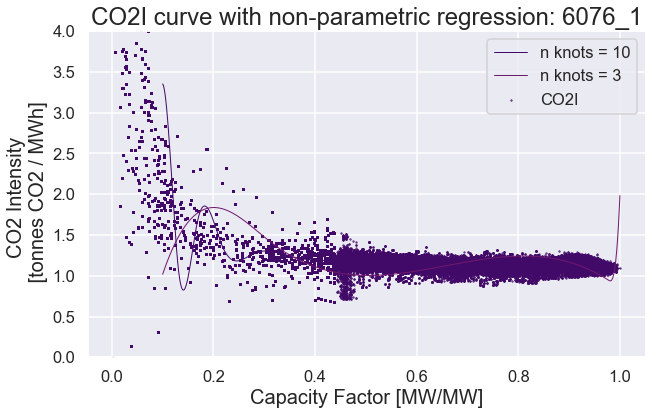

In [50]:
# knots = [[0.01, 0.3] + list(np.linspace(0.35, .99, 100))]
splineFit_explicitKnots(bigSample, 6076, '1', knots, dataFlag=None)

C:\Users\apark2\.julia\conda\3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


Spline model fit + prediction in 0.0469 s
Spline model fit + prediction in 0.0312 s


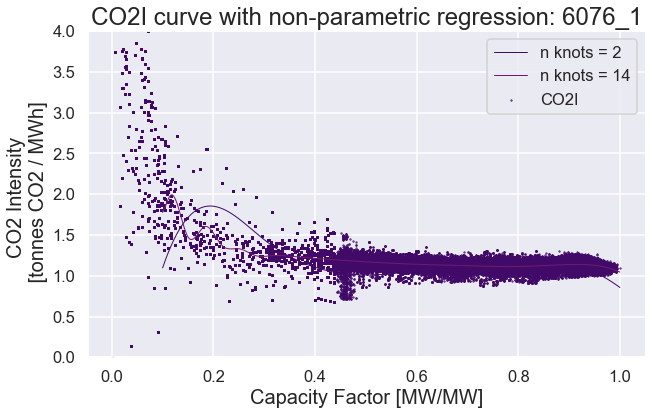

In [51]:
knots = [[0.1, 0.3], list(np.linspace(0.05, .35, 10)) + [0.6, 0.7, 0.8, 0.9]]
splineFit_explicitKnots(bigSample, 6076, '1', knots, dataFlag=None)

May need to sample points proportionally to variance?

OR nonuniform knots!

#### Repeat for all plants and units 

Read in all ORISPL, UNITID.

In [38]:
WI_units = pd.read_csv('C:/Users/apark2/Documents/Year 2/Research/Analysis/Heat Rate Work/ORISPL_UNITID.csv')

In [39]:
WI_units.head()

,ORISPL_CODE,UNITID
0,9,CTG-1
1,87,1
2,113,1
3,113,2
4,113,3


In [40]:
avgCF = pd.read_csv('avgCF.csv')
avgCF.head()

,ORISPL_CODE,UNITID,CF_06_08,CF_15_17
0,9.0,CTG-1,0.586067,0.442420
1,87.0,1,0.842017,0.621213
2,113.0,1,0.852415,0.703109
3,113.0,2,0.880444,0.781279
4,113.0,3,0.899512,0.676210


In [41]:
print(WI_units.shape[0])
print(avgCF.shape[0])  # generated from WI_units, so that makes sense.

745
745


But we only want those with all rows filled out.

In [42]:
avgCF.dropna(inplace=True)

In [43]:
print(avgCF.shape[0])

470


Now we need to make a few changes to LOWESS() to plot lines for each of the average CFs.

In [72]:
def LOWESS_CO2I_est(data, f, orispl, unit, CF1, CF2, dataFlag=''):
    """
    This fits with weighted local regression.
    Data = X and y for fitting
    Orispl, unit = Power generating unit
    f = Fraction of data to use for fit
    dataFlag = Indicates type of datat used: ['full', 'bootstrap', or 'rep_sample']
    CF1, CF2 = CF baselines for which we'll calculated CO2I 
    """
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_prop_cycle('color',plt.cm.inferno(np.linspace(0.2,1,8)))

    print('n points =', data.shape[0])
    x = data['gload']
    y = data['CO2I']

    lowess = sm.nonparametric.lowess
    t0 = time.time()
    # NOTE: y, x for some reason
    x_y_pred = lowess(y, x, frac=f, it=3)
    t = time.time() - t0
    print('LOWESS model prediction in {} s'.format(round(t, 4)))
    # plot results     
    ax.plot(x_y_pred[:, 0], x_y_pred[:, 1], color='gold', label='LOWESS')

    # find closest point, get CO2I there, and plot
    CO2I1 = x_y_pred[np.argmin(abs(x_y_pred[:, 0] - CF1)), 1]  
    CO2I2 = x_y_pred[np.argmin(abs(x_y_pred[:, 0] - CF2)), 1]
    ax.axvline(CF1, label="Avg CF '06-'08", color='lightseagreen')
    ax.axvline(CF2, label="Avg CF '15-'17", color='teal')
    print('CF: ', CF1, CF2)
    print('CO2I: ', CO2I1, CO2I2)
    
    filename = get_valid_filename(str(int(orispl)) + "_" + str(unit))
    plt.scatter(x, y, s=0.5)
    plt.xlabel('Capacity Factor [MW/MW]')
    plt.ylabel('CO2 Intensity \n [tonnes CO2 / MWh]')
    plt.ylim([0, 4])
    plt.title("CO2I curve, LOWESS fit: " + str(int(orispl)) + "_" + str(unit))
    plt.legend()
    plt.savefig("CO2Icurve/LOWESS/" + filename + ".png", dpi=1000, bbox_inches="tight")
    plt.show()
    return CO2I1, CO2I2

n points = 223009
LOWESS model prediction in 1.799 s
CF:  0.7 0.5
CO2I:  0.41616496659211033 0.45359578305603215


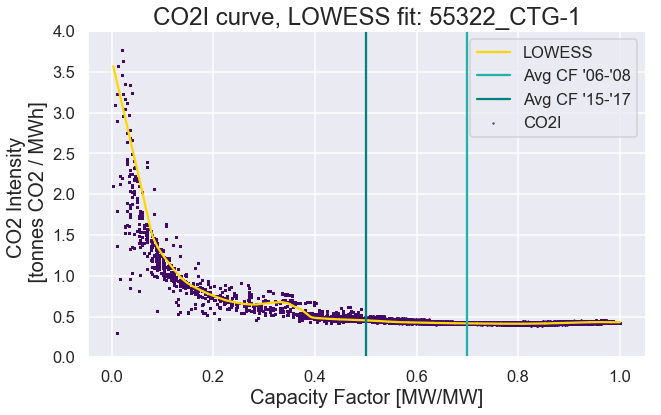

(0.41616496659211033, 0.45359578305603215)

In [171]:
bigSample, capacity = representative_subsample(55322, 'CTG-1', b=25, n=int(1e4))
LOWESS_CO2I_est(bigSample, 0.1, 55322, 'CTG-1', 0.7, 0.5, 'rep_sample')

In [2]:
CO2I_tosave = pd.DataFrame(columns=['ORISPL_CODE', 'UNITID', 'CO2I_06_08', 'CO2I_15_17'])
empty = pd.DataFrame(columns=['ORISPL_CODE', 'UNITID'])
# weird_filename = pd.DataFrame(columns=['ORISPL_CODE', 'UNITID'])
# weird_filename.loc[len(empty)] = [plant, unit]
f = 0.1

for i, row in avgCF.iterrows():
    print(row)
    plant = int(row[0])
    unit = row[1]
    CO2I = row[-2], row[-1]
    filename = "CO2Icurve/LOWESS/" +  str(plant) + "_" + str(unit) + ".png"
    print(filename)
    print(os.path.isfile(filename))
    if os.path.isfile(filename): 
        print('-------------------------')
        continue  # not done already
    bigSample, capacity = representative_subsample(plant, unit, b=25, n=int(1e4))
    if not bigSample is None:
        
        CO2I1, CO2I2 = LOWESS_CO2I_est(bigSample, f, *row)
        newRow = [plant, unit, CO2I1, CO2I2]
        CO2I_tosave.loc[len(CO2I_tosave)] = newRow
    else:
        empty.loc[len(empty)] = [plant, unit]
    print('-------------------------')
CO2I_tosave.to_csv('CO2I_change_LOWESS.csv', index=False)
empty.to_csv('plants_missing_CO2I.csv', index=False)
# weird_filename.to_csv('weird_filename.csv', index=False)

To do:
1. Plot avg CF top of local regression fits.
1. Optimize frac parameter.
2. Consider increasing severity of distance weighting / iterations used when tail error is heavy. (initial results suggests it helps, but it's expensive).
2. Do for many plants
4. Filter high gload outliers.

Done
1. Convert Power to CF.
1. Calculate average CF for each plant for $2006-2008$ and $2015-2017$ baselines.
2. Find a way to fit splines without strictly increasing $x$
3. Filter for CO2I > 0.35

In [70]:
get_valid_filename(value)

'399_10A'